# imports

In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np 
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


# PCA class

In [2]:
import numpy as np

class PCA_class:
    """
    Principal Component Analysis (PCA) class.
    
    Parameters
    ----------
    n_components : int, optional
        Number of components to keep.
    svd_solver : str, optional
        Solver to use for the decomposition. Currently not used.
    """
    def __init__(self, n_components=None, svd_solver='full'):
        self.n_components = n_components
        self.svd_solver = svd_solver
        self.mean = None
        self.components = None
        self.explained_variance_ratio_ = None

    def fit(self, X, method='svd'):
        """
        Fit the model with X using the specified method.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.
        method : str, optional
            Method to use for the decomposition ('svd' or 'eigen').
        """
        # Mean centering
        self.mean = np.mean(X, axis=0)  # Compute the mean of X
        X = X - self.mean  # Subtract the mean from X

        # Handle number of components
        if self.n_components is None:
            self.n_components = min(X.shape) - 1


        if method == 'svd':
            # Compute SVD
            U, S, Vt = np.linalg.svd(X, full_matrices=False)  # Perform SVD on X

            # Compute explained variance ratio
            explained_variance_ = (S ** 2) / (X.shape[0] - 1)  # Compute the explained variance
            total_variance = explained_variance_.sum()  # Compute the total variance
            explained_variance_ratio_ = explained_variance_ / total_variance  # Compute the explained variance ratio

            self.components = Vt[:self.n_components]  # Keep the first n_components components
            self.explained_variance_ratio_ = explained_variance_ratio_[:self.n_components]  # Keep the explained variance ratio for the first n_components

        elif method == 'eigen':
            # Compute covariance matrix
            covariance_matrix = np.dot(X.T, X)  # Compute the covariance matrix of X

            # Compute eigenvalues and eigenvectors
            eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)  # Compute the eigenvalues and eigenvectors of the covariance matrix

            # Sort eigenvalues and eigenvectors by decreasing eigenvalues
            idx = eigenvalues.argsort()[::-1]  # Get the indices that would sort the eigenvalues in decreasing order
            eigenvalues = eigenvalues[idx]  # Sort the eigenvalues
            eigenvectors = eigenvectors[:, idx]  # Sort the eigenvectors accordingly

            # Compute explained variance ratio
            total_variance = eigenvalues.sum()  # Compute the total variance
            explained_variance_ratio_ = eigenvalues / total_variance  # Compute the explained variance ratio

            self.components = eigenvectors[:, :self.n_components].T  # Keep the first n_components components
            self.explained_variance_ratio_ = explained_variance_ratio_[:self.n_components]  # Keep the explained variance ratio for the first n_components

        else:
            raise ValueError("Invalid method. Expected 'svd' or 'eigen'.")
        return self

    def project(self, X):
        """
        Apply dimensionality reduction to X.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            New data.
            
        Returns
        -------
        X_new : array-like, shape (n_samples, n_components)
            Transformed values.
        """
        X = X - self.mean  # Mean centering
        return np.dot(X, self.components.T)  # Project X onto the principal components

    def fit_transform(self, X, method='svd'):
        """
        Fit the model with X and apply the dimensionality reduction on X.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.
        method : str, optional
            Method to use for the decomposition ('svd' or 'eigen').
            
        Returns
        -------
        X_new : array-like, shape (n_samples, n_components)
            Transformed values.
        """
        self.fit(X, method)  # Fit the model with X
        return self.transform(X)  # Apply the dimensionality reduction on X


# A Function to store the images according to folders structure

In [3]:
# Configured by the user 
structure_number = 'one' # Dataset folder, containing subfolders named after subjects, each containing a minimum of 5 images, with extra images limited to the quantity of the smallest subject folder.
dataset_dir = '../face_recognition_dataset'
# Test size is 20% by default
# PCA cumulativa variance is 90% by default

The number of principal components: 319
(96, 320)


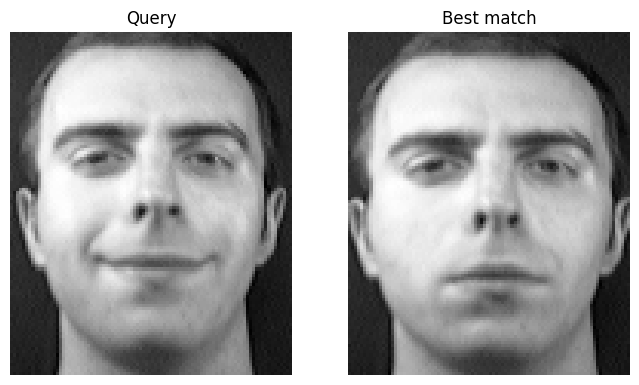

In [4]:
class Backend():

    def __init__(self) -> None:
        self.weights = None
        self.eigen_faces = None
        self.face_recognition_threshold = 2900

        
    
    def store_dataset_method_one(self, dataset_dir):
        self.faces_train = dict()
        self.faces_test = dict()

        # Initialize a variable to store the size of the first image
        self.first_image_size = None

        for subject in os.listdir(dataset_dir): 
            images = []
            if subject == 'no match':
                # Add to self.faces_test['no match']
                subject_dir = os.path.join(dataset_dir, subject)
                self.faces_test[subject] = [cv2.imread(os.path.join(subject_dir, filename), cv2.IMREAD_GRAYSCALE) for filename in sorted(os.listdir(subject_dir))]
                continue
           
            # if subjcet is not 'no match'
            subject_dir = os.path.join(dataset_dir, subject)
            
            for filename in sorted(os.listdir(subject_dir)):
                image = cv2.imread(os.path.join(subject_dir, filename), cv2.IMREAD_GRAYSCALE)
                
                # If first_image_size is None, this is the first image
                # So, store its size and don't resize it
                if self.first_image_size is None:
                    self.first_image_size = image.shape
                
                images.append(image)

            # Warning for the user that the minimum number of faces per subject is 5
            if len(images) >= 5 :
                # Split the data: 80% for training, 20% for testing
                split_index = int(len(images) * 0.8)
                self.faces_train[subject] = images[:split_index]
                self.faces_test[subject] = images[split_index:]

        # Resize images of 'no match' to match the size of the first image
        if 'no match' in self.faces_test:
            for i, image in enumerate(self.faces_test['no match']):
                self.faces_test['no match'][i] = cv2.resize(image, (self.first_image_size[1], self.first_image_size[0]))

        return self.faces_train, self.faces_test


    def store_dataset(self, structure_number: str = 'one', dataset_dir: str = None) -> None:

        # Define a dictionary that maps structure numbers to functions
        methods = {
            'one': self.store_dataset_method_one,
        }

        # Get the function from the dictionary
        func = methods.get(structure_number)

        # Check if the function exists
        if func is not None:
            # Call the function
            func(dataset_dir)
        else:
            print(f"No function named 'store_dataset_method_{structure_number}' found.")

    def train_pca(self, faces_train: dict):

        faces_train_pca = faces_train.copy()
        # Use list comprehension to flatten images and create labels
        train_faces_matrix = []
        self.train_faces_labels = []
        for subject, images in faces_train_pca.items():
            train_faces_matrix.extend(img.flatten() for img in images)
            self.train_faces_labels.extend([subject] * len(images))
        self.train_faces_matrix = np.array(train_faces_matrix)
        # Create instance of the class
        pca = PCA_class().fit(self.train_faces_matrix, 'svd')
        sorted_eigen_values = np.sort(pca.explained_variance_ratio_)[::-1]
        print(f"The number of principal components: {len(sorted_eigen_values)}")
        cumulative_variance = np.cumsum(sorted_eigen_values)
        # let's assume that we will consider just 90 % of variance in the data, so will consider just first 101 principal components  
        upto_index = np.where(cumulative_variance < 0.9)[0][-1] # the last one 
        no_principal_components = upto_index + 1
        self.eigen_faces = pca.components[:no_principal_components]
        self.weights = self.eigen_faces @ (self.train_faces_matrix - np.mean(self.train_faces_matrix, axis=0)).transpose()
        print(self.weights.shape) # row vector for each image in the face matrix which indicates the linear conbination of the PCAs what would generate that image.  
        return self

    def recognise_face(self, test_face: np.ndarray):

        test_face_to_recognise = test_face.copy()
        if test_face_to_recognise.shape != self.first_image_size:
            test_face_to_recognise = cv2.resize(test_face_to_recognise, self.first_image_size)
        test_face_to_recognise = test_face_to_recognise.reshape(1,-1)
        test_face_weights = self.eigen_faces @ (test_face_to_recognise - np.mean(self.train_faces_matrix, axis=0)).transpose()
        distances = np.linalg.norm(self.weights - test_face_weights, axis = 0 ) # compare row wise 
        best_match = np.argmin(distances)
        best_match_subject, best_match_subject_distance = self.train_faces_labels[best_match] , distances[best_match]
        if best_match_subject_distance > self.face_recognition_threshold:
            best_match_subject = 'no match'
        else: best_match_subject = best_match_subject
    
        return best_match_subject, best_match_subject_distance, best_match

    def test_faces_and_labels(self, test_faces_dict:dict) -> (list, list): # type: ignore
        test_faces_dictionary = test_faces_dict.copy()
        # Flatten the test faces and create corresponding labels
        test_faces = []
        test_labels = []
        for subject, faces in test_faces_dictionary.items():
            for face in faces:
                test_faces.append(face)
                # Encode the labels, no match -> 0, otherwise -> 1
                label = 0 if subject == 'no match' else 1
                test_labels.append(label)
        return test_faces, test_labels


    def ROC_curve(self, test_faces_dict: dict):

        test_faces_dictionary = test_faces_dict.copy()
        test_faces_list, test_labels_list = self.test_faces_and_labels(test_faces_dictionary)
        # Calculate the distances for each test face
        _, distances, _ = zip(*[self.recognise_face(face) for face in test_faces_list])

        # Define the thresholds based on the distances
        thresholds = np.linspace(min(distances), max(distances), 100)

        tpr_values = []
        fpr_values = []

        for threshold in thresholds:
            true_positive = 0
            false_positive = 0
            true_negative = 0
            false_negative = 0

            for i, distance in enumerate(distances):
                if distance < threshold and test_labels_list[i] == 1:
                    true_positive += 1
                elif distance < threshold and test_labels_list[i] == 0:
                    false_positive += 1
                elif distance >= threshold and test_labels_list[i] == 1:
                    false_negative += 1
                elif distance >= threshold and test_labels_list[i] == 0:
                    true_negative += 1

            tpr = true_positive / (true_positive + false_negative)
            fpr = false_positive / (false_positive + true_negative)

            tpr_values.append(tpr)
            fpr_values.append(fpr)

        plt.plot(fpr_values, tpr_values)
        plt.plot([0, 0.93], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')

        # Highlight the 2900 threshold
        threshold_2900_tpr = tpr_values[np.argmin(np.abs(thresholds - 2900))]
        threshold_2900_fpr = fpr_values[np.argmin(np.abs(thresholds - 2900))]
        plt.scatter(threshold_2900_fpr, threshold_2900_tpr, color='red')
        plt.text(threshold_2900_fpr, threshold_2900_tpr, 'Threshold 2900')

        plt.show()

    def show_test_images(self,test_faces_dict: dict, indx): 
        test_faces_dictionary = test_faces_dict.copy()
        test_faces_list, test_labels_list = self.test_faces_and_labels(test_faces_dictionary)

        indx = indx % len(test_labels_list)
        best_match_subject, best_match_subject_distance, best_match_indx = self.recognise_face(test_faces_list[indx]) 
        if best_match_subject_distance < self.face_recognition_threshold:
            # Visualize
            fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
            axes[0].imshow(test_faces_list[indx], cmap="gray")
            axes[0].set_title("Query")
            axes[1].imshow(self.train_faces_matrix[best_match_indx].reshape(self.first_image_size), cmap="gray")
            axes[1].set_title("Best match")
            axes[0].axis("off")
            axes[1].axis("off")
        else: 
            print('Query out of threshold')
            # Visualize
            fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
            axes[0].imshow(test_faces_list[indx], cmap="gray")
            axes[0].set_title("Query")
            # Display a blank image as placeholder for no matching subject
            no_match_image = np.full_like(self.train_faces_matrix[0].reshape(self.first_image_size), 255, dtype=np.uint8)  
            axes[1].imshow(no_match_image, cmap="gray")
            axes[1].set_title("No matching subject")
            axes[0].axis("off")
            axes[1].axis("off")

    
backend_instance = Backend()
# each one is a dictionary, where the keys() are the subject names, the values() are a list of images
# for example, to acess the 2nd image in subject 's2' in the training dataset is: faces_train['s2'][1] -> 2D greyscale array
faces_train, faces_test = backend_instance.store_dataset_method_one(dataset_dir)
backend_instance.train_pca(faces_train) # Here, we create an instance of PCA_class and train it
backend_instance.show_test_images(faces_test,20)


In [ ]:
backend_instance.ROC_curve(faces_test)